# Matching Score Measure (MSM) Confidence Measure

## Stereo Depth Estimation
Stereo depth estimation expoits the parallax (apparent displacement of an object along two different lines of sight) to estimate disparity. Disparity is the difference in horizontal location of an object between the left and right images. The disparity can be used to calculate the real world distance to the object using the formula: 
$$z = \dfrac{fB}{d}$$
,where z is the depth, B is the baseline distance between the two cameras, and d is the disparity. The baseline and focal length is very easy to obtain and is constant, so disparity is the only difficult value to obtain in the equation.

I will be using Heiko Hirschmuller's [semi-global matching](https://core.ac.uk/download/pdf/11134866.pdf) techinque to estimate depth using rectified stereo images. I wont explain how SGM works in this notebook as it would get too long. If you don't know how SGM works, I recommend visiting my notebook [Semi-Global Matching Numpy](https://github.com/ChristianOrr/semi-global-matching-numpy) for a breakdown.

## Confidence Estimation
Disparity estimation algorithms will occasionally perform missmatches, resulting in incorrect disparity values. Confidence estimation helps resolve this issue by providing a confidence estimate for each disparity estimate. Higher confidence values indicate that the disparity estimate is more likely to be accurate. The disparity maps accuracy can be improved by using the confidence estimates to identify and remove false disparity values. 

There are dozens of different confidence measures ranging in speed and accuracy. To learn more about the different types of confidence measures see [On the confidence of stereo matching in a deep-learning era: a quantitative evaluation](https://arxiv.org/abs/2101.00431) by M. Poggi et al.

## Matching Score Measure
We will be implementing a method called [Matching Score Measure (MSM)](http://www.cse.yorku.ca/~wildes/wildesVI02.pdf) by G. Egnal, M. Mintz, and R. Wilde. This is a handcrafted confidence measure designed to be fast. The algorithm will be implemented from scratch in numpy. At the end of the notebook we will review the algorithms ability to identify incorrect disparities. 


In [1]:
import cv2
import numpy as np
from sgm_numpy import sgm
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ipywidgets import interact, widgets

from helper_funcs import normalize, colorize_image, select_disparity, filter_disparity
from evaluation_funcs import calc_roc, calc_auc

In [2]:
left_name = 'teddy/im2.png' # name (path) to the left image
right_name = 'teddy/im6.png' # name (path) to the right image
left_gt_name = 'teddy/disp2.png' # name (path) to the left ground-truth image
right_gt_name = 'teddy/disp6.png' # name (path) to the right ground-truth image

max_disparity = 64 # maximum disparity for the stereo pair
P1 = 10 # penalty for disparity difference = 1
P2 = 120 # penalty for disparity difference > 1
csize = (5, 5) # size of the kernel for the census transform.
bsize = (3, 3) # size of the kernel for blurring the images and median filtering.
tau = 3 # Used for D1 error rate: number of disparities with difference > tau
conf_threshold = 0.8 # retain disparitys with confidence greater than the conf_threshold

### Load The Images

The images are loaded into grayscale format. We will only be using the intensities of the pixels, so the RGB information is not needed.

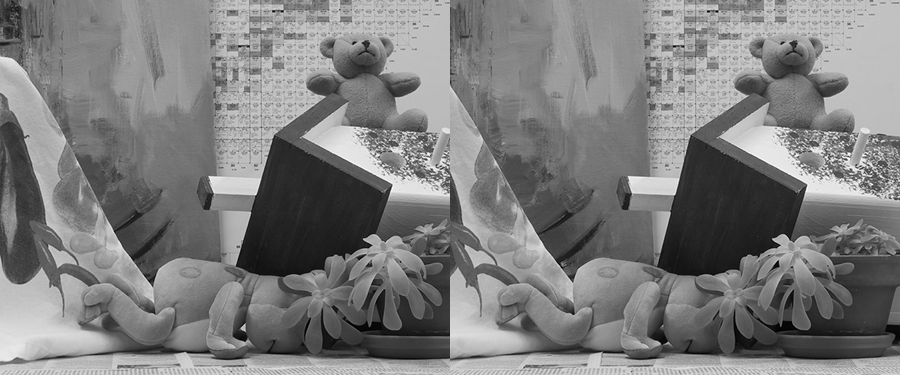

In [3]:
left = cv2.imread(left_name, cv2.IMREAD_GRAYSCALE)
right = cv2.imread(right_name, cv2.IMREAD_GRAYSCALE)

height = left.shape[0]
width = left.shape[1]
assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
assert max_disparity > 0, 'maximum disparity must be greater than 0.'

joined_gray = np.concatenate([left, right], axis=1)
display(Image.fromarray(joined_gray))

### Perform Semi-Global Matching

We need to run SGM to extract the aggregation volume. The aggregation volume will then be used to calculate the disparity and extract the confidence estimates. We are using SGM because it is a fast algorithm. However, it's not a requirement to use the confidence measure. We could replace SGM with any other stereo correspondance algorithm if we desired.

In [4]:
left_aggregation_volume, right_aggregation_volume = sgm(left, right, max_disparity, P1, P2, csize, bsize, height, width)

Performing Gaussian blur on the images...

Starting cost computation...
	Computing left and right census...	(done in 1.42s)
	Computing cost volumes...	(done in 3.20s)

Starting left aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 3.81s)

Starting right aggregation computation...
	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 3.79s)


### Display Disparities

Now we can use the aggregation volumes to extract the disparity maps and compare them to the groundtruth.


Selecting best disparities...

Applying median filter...


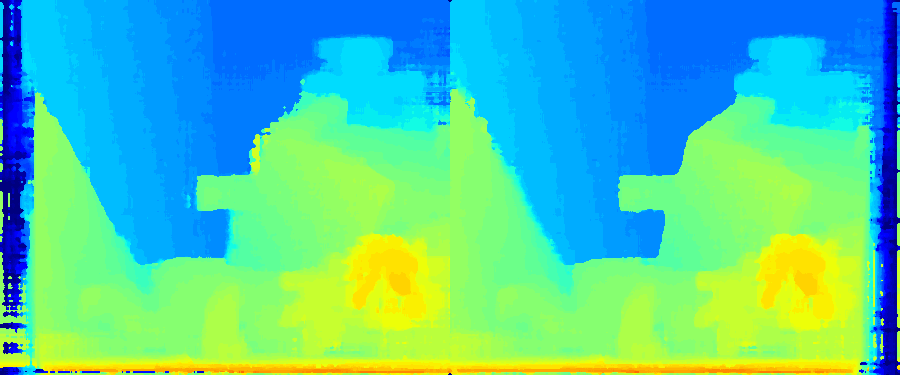

In [5]:
print('\nSelecting best disparities...')
left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), max_disparity))
right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), max_disparity))
print('\nApplying median filter...')
left_disparity_map = cv2.medianBlur(left_disparity_map, bsize[0])
right_disparity_map = cv2.medianBlur(right_disparity_map, bsize[0])


left_depth_map = colorize_image(left_disparity_map)
right_depth_map = colorize_image(right_disparity_map)

joined_depth_map = np.concatenate([left_depth_map, right_depth_map], axis=1)
display(Image.fromarray(joined_depth_map))

### Display Groundtruth Disparities

The SGM disparity is not far off from the groundtruth shown below, but it performs poorly near the edges of the objects. We will see in the next section if the MSM confidence measure can identify these incorrect disparities.

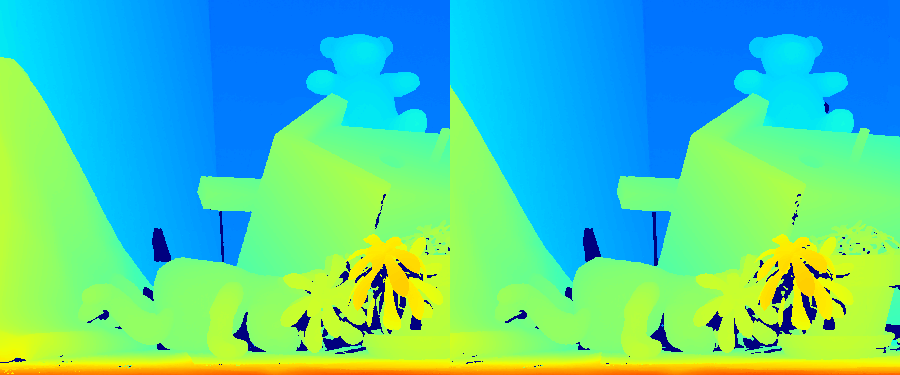

In [6]:
left_gt = cv2.imread(left_gt_name, cv2.IMREAD_GRAYSCALE)
right_gt = cv2.imread(right_gt_name, cv2.IMREAD_GRAYSCALE)

left_depth_map_gt = colorize_image(left_gt)
right_depth_map_gt = colorize_image(right_gt)

joined_depth_map_gt = np.concatenate([left_depth_map_gt, right_depth_map_gt], axis=1)
display(Image.fromarray(joined_depth_map_gt))

### MSM Algorithm Explanation

Now its time to create the MSM algorithm. We start by converting the aggregation volume into a single cost volume. Each pixel in the cost volume will have a cost curve. The cost curve is a sequence of matching costs for each disparity. MSM works by negating the minimum cost value in the cost curve. The cost's represent how good the match was at that disparity, so higher cost means worse match and lower cost means a better match. The idea behind MSM is that the minimum cost in the cost curve is inversely proportional to the confidence of the disparity estimate. Hence, we can take the negative of the minimum cost value, which provide a low confidence value when the minmium cost is high and a high confidence value when the minimum cost is low.  


### MSM Equation
The MSM confidence estimation equation is given by:
$$MSM(p) = -C_{d_1}(p)$$ 
, where $C_{d_1}(p)$ is the cost at position $d_1$, $p$ is the pixel and $d_1$ is the disparity with minimum cost in the cost curve.


### Cost Curve Example
An Example of a cost curve from [On the confidence of stereo matching in a deep-learning era: a quantitative evaluation](https://arxiv.org/abs/2101.00431) by M. Poggi et al. is shown below. $C_{d_1}$ is the minimum cost in the cost curve. Its cost value is 0.1. Using MSM, its confidence would be -0.1. This is then normalized to get a convenient value between 0-1.

![Cost Curve Example](./figures/cost-curve-example.png)


In [7]:
def matching_score_measure(aggregation_volume, csize):
    """
    Creates a confidence map (H x W) using the 
    matching score measure technique from the 
    aggregation volume (H x W x D x N).

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N.
        - csize: kernel size for the census transform.

    Returns: Confidence map with normalized values (0-1) and 
        dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3, dtype=np.int32)     
    # returns the minimum cost associated with each h x w pixel
    min_costs = np.min(volume, axis=2) 
    # Negate the cost so that lower is less confidant and higher is more confident
    min_costs = -min_costs
    # Normalize to get confidence values between 0-1
    minimum = np.min(min_costs)
    maximum = np.max(min_costs)
    confidence = (min_costs - minimum) / (maximum - minimum)
    # Set border pixels confidence to 0 (since disparity couldn't be calculated there)
    confidence[:csize[0], :] = 0 # top border
    confidence[-csize[0]:, :] = 0 # bottom border
    confidence[:, :csize[1]] = 0 # left border
    confidence[:, -csize[1]:] = 0 # right border
    return confidence

### Plot Confidence Maps

We will now plot the confidence maps by quantizing their values. The confidences are colorized using the winter color map to make the confidence differences easier to see. Dark blue represents low confidence and light green represents high confidence. The disparity maps shown previously displayed low accuracy around the edges of the objects, the confidence maps below have done a good job at identifying these regions.


Calculating confidences...


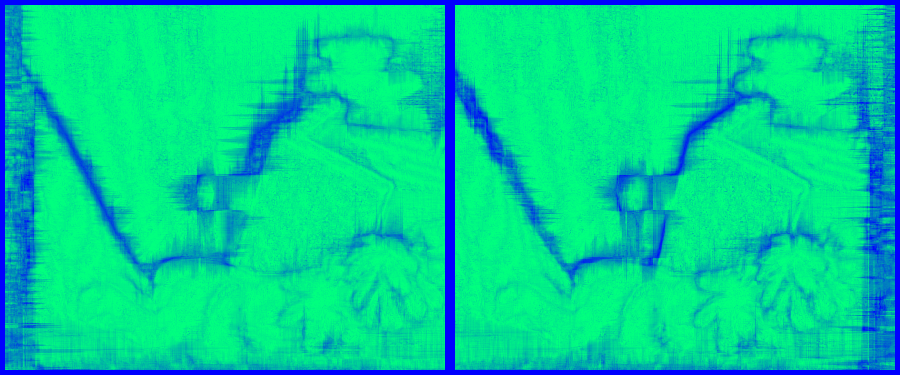

In [8]:
print("\nCalculating confidences...")
left_confidences = matching_score_measure(left_aggregation_volume, csize)
right_confidences = matching_score_measure(right_aggregation_volume, csize)

joined_confidences = np.concatenate([
    colorize_image(np.uint8(left_confidences * 255), "winter"), 
    colorize_image(np.uint8(right_confidences * 255), "winter")], axis=1)
display(Image.fromarray(joined_confidences))

### Filter Low Confidence Disparities

We can achieve a more accurate disparity map by using the condifence maps to remove the low confidence disparities, as shown below. The confidence threshold can be set to any value between 0-1, with higher values retaining the most confident disparities. Higher thresholds come at the cost of a more sparse disparity map, so its not always better to use a higher confidence threshold. The ideal threshold value will depend on the use case and on the accuracy of the confidence estimator at the different confidence levels, which we will explore in the next section.

In [9]:
def update(threshold = 0.8):
    left_filtered_disp = filter_disparity(left_disparity_map, left_confidences, threshold)
    right_filtered_disp = filter_disparity(right_disparity_map, right_confidences, threshold)

    joined_filtered_disp = np.concatenate([
        colorize_image(left_filtered_disp, "jet"), 
        colorize_image(right_filtered_disp, "jet")], axis=1)
    display(Image.fromarray(joined_filtered_disp))

interact(update, threshold = widgets.FloatSlider(min = 0, max = 1.0, step = 0.05, value = conf_threshold))

interactive(children=(FloatSlider(value=0.8, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

<function __main__.update(threshold=0.8)>

### Evaluate Confidence Measure

We need to measure the effectiveness of the confidence measure at detecting correct matches. For this purpose we will be using the evaluation methods from "A quantitative evaluation of confidence measures for stereo vision" by X. Hu and P. Mordohai. 

The first step of the evaluation is to order the disparities in decreasing order of confidence. Then we calculate the error rate on the sorted disparities with increasing density. This provides us with an array of errors for cumulutive densities, which will be used for the y-axis in the roc curve. The x-axis is increasing density. The densities are calculated based on 5% intervals of the total data. The errors are calculated as the absolute difference of the estimated disparity and groundtruth greater than tau, where tau is usually 3 pixels.

This results in ROC curves of error rate as a function of density, which is essentially a cumulitive error distribution.


In [10]:
left_roc, left_optimal_roc, left_mean_error, left_sorted_conf, ratio_pixels = calc_roc(left_disparity_map, left_gt, left_confidences, tau)
right_roc, right_optimal_roc, right_mean_error, right_sorted_conf, ratio_pixels = calc_roc(right_disparity_map, right_gt, right_confidences, tau)

### Optimal ROC Curve for Error Rate (Optimal Cumulitive Error Distribution)

The optimal ROC Curve is based on the hypothetical situation where the confidence measure correctly identifies all incorrect disparities with low confidence and all correct matches with high confidence. This results in a monotonically increasing curve. In reality no confidence measure will achieve this level of accuracy. This is used to provide us with an understanding of the limits of the algorithm. 

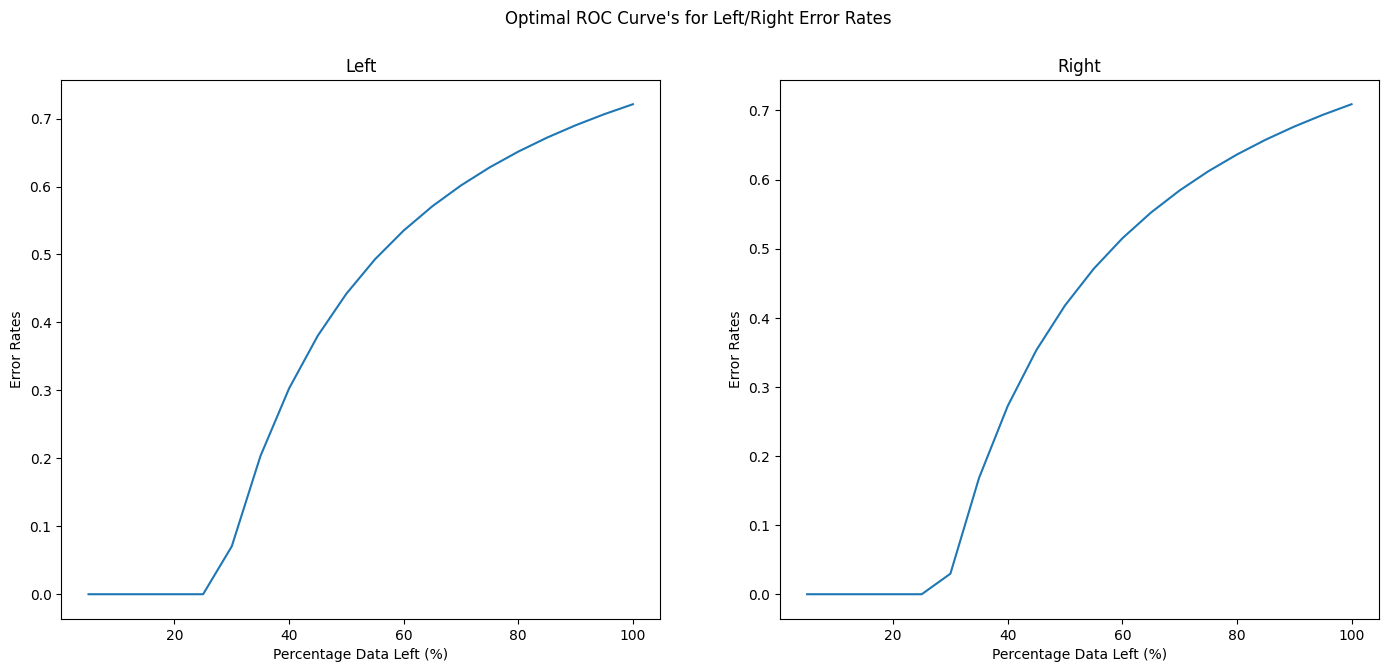

In [11]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("Optimal ROC Curve's for Left/Right Error Rates")
x_values = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_optimal_roc)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")

# Right
right_ax.plot(x_values, right_optimal_roc)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")
plt.show()

### ROC Curve for Error Rate (Cumulitive Error Distribution)

As you can see below the MSM ROC curve is far from the optimal ROC shown above. The curve initially decreases before increasing, this indicates that the errors at the highest confidence levels are actually higher than at lower confidence levels. The lowest error rates are at about 70% density. This tells us how much data we need to filter out to achieve the lowest error rates. Note that this is a single example, so it may change for other images. In the next step we will find out the confidence thresholds needed to achieve the lowest error rate (at 70% density).

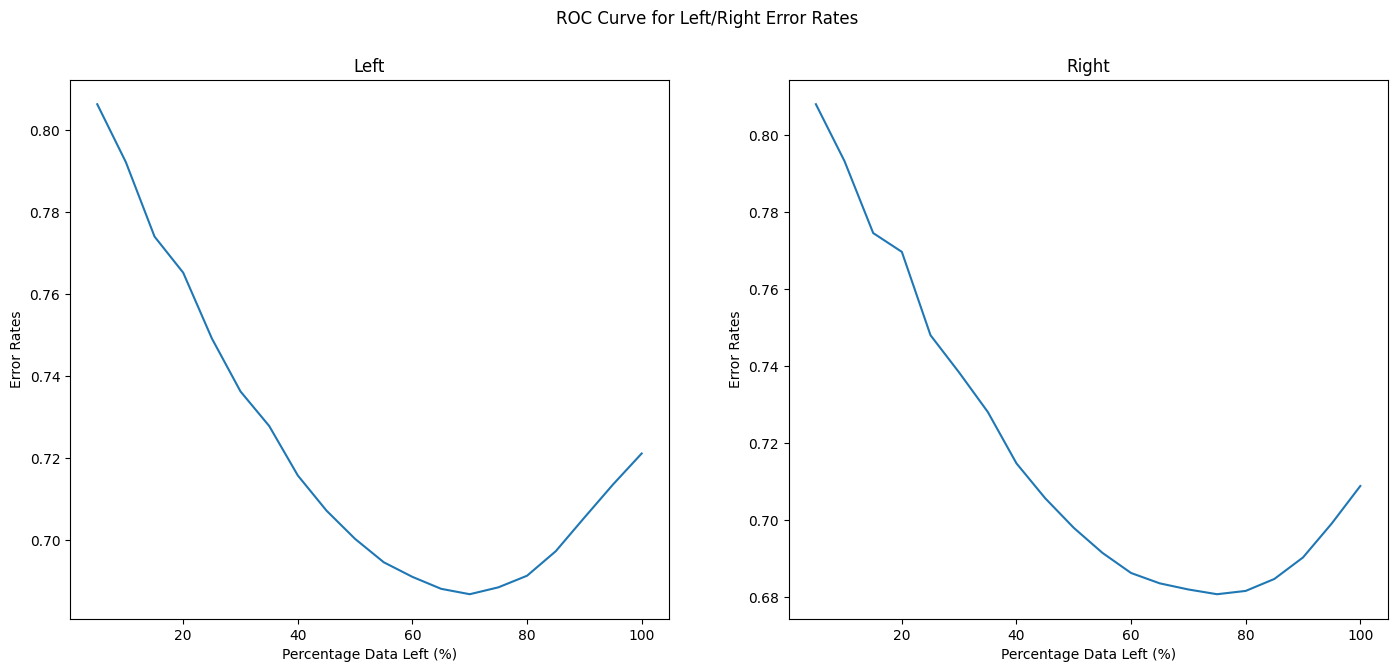

In [12]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("ROC Curve for Left/Right Error Rates")
x_values = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_roc)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")

# Right
right_ax.plot(x_values, right_roc)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Error Rates")
plt.show()

### Ratio of Data Filtered Per Confidence Value

We discovered previously that to achive the lowest error rate we need to filter out approximately 30% of the disparities, but we didn't know what confidence threshold was required. So now I've plotted the confidence values used at all the density intervals. The plots show us that to achieve 70% density we need to use a confidence threshold of approximately 0.8. As mentioned previously this may change for different images, so this process would need to be repeated for multiple images to get a more accurate threshold. 

In [13]:
# Confidence values at each interval of cumulitive data
left_conf_at_ratios = []
for ratio in ratio_pixels:
    index = int(left_sorted_conf.shape[0] * ratio)
    left_conf_at_ratios.append(left_sorted_conf[index - 1])

right_conf_at_ratios = []
for ratio in ratio_pixels:
    index = int(right_sorted_conf.shape[0] * ratio)
    right_conf_at_ratios.append(left_sorted_conf[index - 1])

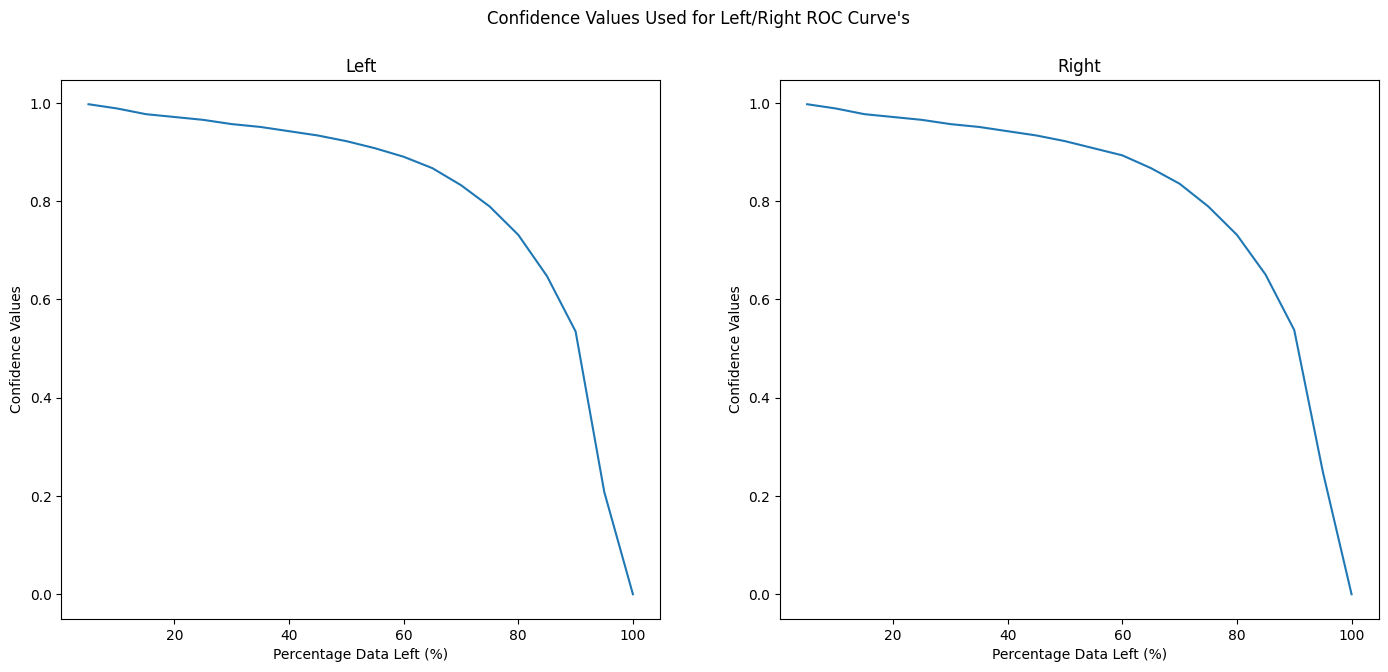

In [14]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(17, 7))
fig.suptitle("Confidence Values Used for Left/Right ROC Curve's")
x_values = [ratio * 100 for ratio in ratio_pixels]
conf_at_ratios = [ratio * 100 for ratio in ratio_pixels]

# Left
left_ax.plot(x_values, left_conf_at_ratios)
left_ax.set_title("Left")
left_ax.set(xlabel="Percentage Data Left (%)", ylabel="Confidence Values")

# Right
right_ax.plot(x_values, right_conf_at_ratios)
right_ax.set_title("Right")
right_ax.set(xlabel="Percentage Data Left (%)", ylabel="Confidence Values")
plt.show()

### Calculate AUC

We need to convert the information from the ROC curve into a more digestible form. We will be using area under the ROC curve (AUC) to create a single number to evaluate the confidence measures performance. AUC performs integration over the ROC curve, which is essentially the average error over all densities. 

Lower AUC values are better, but the AUC may not go any lower than the optimal AUC, this represents the lower limit of AUC. The AUC value also shouldn't go above the error at 100% density. If it does go above, then it means that the confidence measure is worse than a random function. 


### AUC Results
The AUC for both left and right images are below the total error. Which is a good result, but its far from the optimal AUC. Showing us there is a lot of room for improvement. This algorithm is designed for speed, so its not surprising that is lacking in accuracy.

In [15]:
left_auc, left_optimal_auc = calc_auc(left_roc, left_optimal_roc)
right_auc, right_optimal_auc = calc_auc(right_roc, right_optimal_roc)

print("\nLeft Results: ")
print(f"\tTotal Error: {left_mean_error:.3f}, AUC: {left_auc:.3f}, Optimal AUC: {left_optimal_auc:.3f}")
print("\nRight Results: ")
print(f"\tTotal Error: {right_mean_error:.3f}, AUC: {right_auc:.3f}, Optimal AUC: {right_optimal_auc:.3f}")


Left Results: 
	Total Error: 0.721, AUC: 0.684, Optimal AUC: 0.365

Right Results: 
	Total Error: 0.709, AUC: 0.680, Optimal AUC: 0.350
